In [21]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from matplotlib import pylab as plt 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
from seqmm import SeqUDSklearn, SeqUDOptimizer, GPEISklearn,\
        SMACSklearn, TPESklearn, GridSklearn, RandSklearn, LHSSklearn, SobolSklearn, UDSklearn

dt = datasets.load_diabetes()
sx = MinMaxScaler()
sy = MinMaxScaler()
x = sx.fit_transform(dt.data)
y = sy.fit_transform(dt.target.reshape([-1,1]))

ParaSpace = {'booster':          {'Type': 'categorical', 'Mapping': ['gbtree', 'gblinear']},
             'max_depth':        {'Type': 'integer',     'Mapping': np.linspace(2,10,9)}, 
             'n_estimators':     {'Type': 'integer',     'Mapping': np.linspace(100,500,401)},
             'min_child_weight': {'Type': 'integer',     'Mapping': np.linspace(1,100,100)},
             'subsample':        {'Type': 'continuous',  'Range': [0, 1],  'Wrapper': lambda x:x},
             'colsample_bytree': {'Type': 'continuous',  'Range': [0, 1],  'Wrapper': lambda x:x},
             'learning_rate':    {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'gamma':            {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'reg_lambda':       {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'reg_alpha':         {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x}}

estimator = xgb.XGBRegressor()
score_metric = make_scorer(mean_squared_error, False)
cv = KFold(n_splits=5, random_state=0, shuffle=True)

Fitting model: SeqUD
The best score is -0.02884: 
Fitting model: GPEI
The best score is -0.03006: 
Fitting model: SMAC
The best score is -0.02886: 
Fitting model: TPE
The best score is -0.02885: 


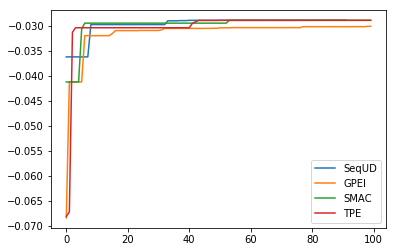

In [24]:
seq_model_zoo = {"SeqUD": SeqUDSklearn, 
                 "SeqRand": SeqRandSklearn,
                  "GPEI": GPEISklearn, 
                  "SMAC": SMACSklearn, 
                  "TPE": TPESklearn}
for item, model in seq_model_zoo.items():
    print("Fitting model: %s"% item)
    clf = model(estimator, cv, ParaSpace, max_runs = 100, scoring =  score_metric, refit = True, verbose = False)
    clf.fit(x, y)
    print("The best score is %0.5f: "% clf.best_score_)
    plt.plot(clf.logs["score"].cummax()) 
plt.legend(seq_model_zoo.keys())

Fitting model: Grid
Fitting model: Rand
Fitting model: LHS
Fitting model: Sobol
Fitting model: UD
No design found.


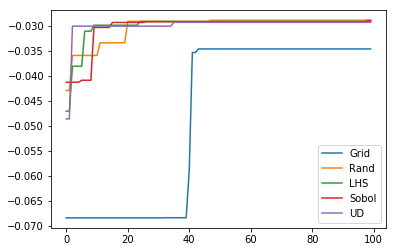

In [25]:
batch_model_zoo = {"Grid": GridSklearn,
                  "Rand": RandSklearn, 
                  "LHS": LHSSklearn, 
                  "Sobol": SobolSklearn, 
                  "UD": UDSklearn}
for item, model in batch_model_zoo.items():
    print("Fitting model: %s"% item)
    clf = model(estimator, cv, ParaSpace, max_runs = 100, scoring =  score_metric, refit = True, verbose = False)
    clf.fit(x, y)
    print("The best score is %0.5f: "% clf.best_score_)
    plt.plot(clf.logs["score"].cummax()) 
plt.legend(batch_model_zoo.keys())

In [ ]:
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

X, y = samples_generator.make_classification(
    n_informative=5, n_redundant=0, random_state=42)

anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])

anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)
ParaSpace = {'anova__k':      {'Type': 'integer', 'Mapping':  np.linspace(2,10,9)},
             'svc__C':        {'Type': 'continuous',     'Range': [-6, 16], 'Wrapper': np.exp2}
            }

cv = KFold(n_splits=5, random_state=0, shuffle=True)
clf = SeqUDSklearn(anova_svm, cv, ParaSpace)
clf.fit(X, y)